# Schelling’s Segregation Model
(https://www.suz.uzh.ch/dam/jcr:00000000-68cb-72db-ffff-ffffff8071db/04.02_schelling_71.pdf)

### Installing additional packages

In [1]:
using Revise 
using Parameters, LinearAlgebra, Statistics, StatsPlots, DataFrames
using StatsBase: sample, countmap
using DataStructures: OrderedDict

ArgumentError: Package `Revise` not found in current path:
- Run `import Pkg; Pkg.add("Revise")` to install the absd package;
- Or go into the package manager in the REPL by typing `]` and adding the package with `add Revise`

## Linear Model
### Setup
- Agents
    - kind of agent (stars or circle)
    - location
    - preferences (conditions which agent is satisfied)
    
- Neighborhood
    - Agents
    - location
    - size

### Struct
Structs are basically a collection of named fields - we can use them to define a collection of interest  
The `@Base.kwdef` macro allows us to use keywords to define the struct

In [2]:
mutable struct Agent
   id
   kind
   location
   neighborhood_size   # Max neighborhood distance to consider to determine share preference
   preference          # Preference ratio for the Agent to be happy
end

In [3]:
@Base.kwdef mutable struct Neighborhood
   agents
   locations
   size
end

Neighborhood

In [4]:
a1 = Agent(1, "Stars", 2, 4, 0.5)
a2 = Agent(2, "Circle", 3, 4, 0.5)

Agent(2, "Circle", 3, 4, 0.5)

In [5]:
nh1 = Neighborhood(agents=[a1, a2], locations=Dict(a1 => 2, a2 => 3), size=2)

Neighborhood(Agent[Agent(1, "Stars", 2, 4, 0.5), Agent(2, "Circle", 3, 4, 0.5)], Dict{Agent,Int64}(Agent(1, "Stars", 2, 4, 0.5) => 2,Agent(2, "Circle", 3, 4, 0.5) => 3), 2)

In [6]:
# Docstring in Julia is written above the function as shown below

"Initializes the neigbourhood by mapping a dictionary of agent types to population size."
function init_neighborhood(population_dict, neighborhood_size, preference)
    
    # Pipe operator |>, equivalent to: sum(collect(values(agent_number)))
    # Similar to R's %>%
    n = population_dict |> values |> collect |> sum 
    location_dict = Dict()

    # Create a list of agents
    pos = sample(1:n, n, replace=false)
    agents = []
    counter = 0
    for (key, value) in population_dict
        for i in 1:value
            id = i + counter
            new_agent = Agent(id, key, pos[id], neighborhood_size, preference)
            
            # Julia has a convention where functions ending with ! modifies their arguments
            # In this case we are inserting a new_agent into the agents list
            push!(agents, new_agent) 
            location_dict[pos[id]] = new_agent
        end
        counter += value
    end
    return Neighborhood(agents=agents, locations=location_dict, size=n)
end

init_neighborhood

### Need help?
Use the '?' sign to get information about a function or an object. Similar to R

In [7]:
?init_neighborhood

search: init_neighborhood



Initializes the neigbourhood by mapping a dictionary of agent types to population size.


In [8]:
?countmap

search:



```
countmap(x; alg = :auto)
```

Return a dictionary mapping each unique value in `x` to its number of occurrences.

  * `:auto` (default): if `StatsBase.radixsort_safe(eltype(x)) == true` then use                    `:radixsort`, otherwise use `:dict`.
  * `:radixsort`:      if `radixsort_safe(eltype(x)) == true` then use the                    [radix sort](https://en.wikipedia.org/wiki/Radix_sort)                    algorithm to sort the input vector which will generally lead to                    shorter running time. However the radix sort algorithm creates a                    copy of the input vector and hence uses more RAM. Choose `:dict`                    if the amount of available RAM is a limitation.
  * `:dict`:           use `Dict`-based method which is generally slower but uses less                    RAM and is safe for any data type.


In [9]:
population_dict = Dict("Stars"=>2, "Circle"=>2)
nh = init_neighborhood(population_dict, 4, 0.5)

Neighborhood(Any[Agent(1, "Stars", 3, 4, 0.5), Agent(2, "Stars", 1, 4, 0.5), Agent(3, "Circle", 4, 4, 0.5), Agent(4, "Circle", 2, 4, 0.5)], Dict{Any,Any}(4 => Agent(3, "Circle", 4, 4, 0.5),2 => Agent(4, "Circle", 2, 4, 0.5),3 => Agent(1, "Stars", 3, 4, 0.5),1 => Agent(2, "Stars", 1, 4, 0.5)), 4)

In [10]:
# Suppress output with the semicolon;
nh = init_neighborhood(Dict("Stars"=>35, "Circle"=>35), 4, 0.5);

### Iteration steps
1) Mark out unhappy actors  
2) Use rule to decide how they move  
3) Move agents  
4) Repeat till everyone is happy / system converged

__Schelling's rules__  
- Wants at least half of the neighbors to be of same type
- Dissatisfied member move to the nearest point which he is satisfied

In [11]:
function is_happy(nh, agent_id)
    a = nh.agents[agent_id]
    neighbors = [
      [nh.locations[i] for i in max(a.location - a.neighborhood_size, 1):a.location-1];
      [nh.locations[i] for i in a.location+1:min(a.location + a.neighborhood_size, nh.size)]
    ]
    neighbors_kind = [a.kind for a in neighbors]
    cmap = countmap(neighbors_kind)
    share = get(cmap, a.kind, 0) / length(neighbors)  # If key does not exist, there are 0 of its kind
    return share ≥ a.preference
end

is_happy (generic function with 1 method)

In [12]:
@show a = nh.locations[2]
is_happy(nh, a.id)

a = nh.locations[2] = Agent(68, "Circle", 2, 4, 0.5)


false

### Visualizing the neighborhood 
StatsPlots should already contain the requirements for Plots, otherwise: Pkg.add("Plots")

In the plot neighborhood function below, we see 3 interesting syntax of Julia:
1. Python style list comprehensions
2. Ternary operators like R or Javascript `a.kind == "Circle" ? :circle : :star` 
3. functions! - nothing special, just a Julia convention to denote functions which modifies their arguments
4. Annonymous functions as concise as Javascript arrow syntax: `x->x[1]`
5. Symbols e.g. `:circle` or `:orange` which are 'special' strings that can be evaluated to values bound to it. See https://stackoverflow.com/questions/23480722/what-is-a-symbol-in-julia

In [13]:
function plot_nh(nh)
    ordered_loc = sort!(OrderedDict(nh.locations), by=x->x[1])
    m = [a.kind == "Circle" ? :circle : :star for a in values(ordered_loc)]
    c = [is_happy(nh, a.id) ? :lightblue : :orange for a in values(ordered_loc)]
    scatter(1:nh.size, ones(nh.size), color=c, m=m, markersize=6,
        axis=false, grid=false, ylimit=[0.8,1.2], legend=false, size=(1000,100))
end

plot_nh (generic function with 1 method)

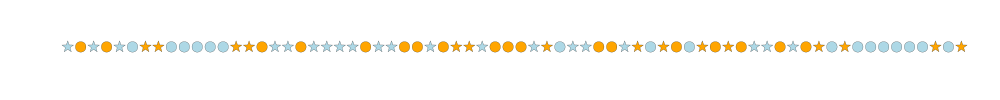

In [14]:
plot_nh(nh)

In [15]:
# Follow the use of exclaimation mark since we are modifying nh

function update!(nh, agent_id)
    # Choose nearest new locations until happy.
    a = nh.agents[agent_id]
    original_location = a.location
    options = [i % 2 == 1 ? ceil(Int64, i/2) : ceil(Int64, -i/2) for i in 1:nh.size*2]
    for i in options
        attempt_location = original_location + i
        if (0 < attempt_location <= nh.size)
            # @show (original_location, attempt_location)
            move_location!(nh, a, attempt_location)
            if is_happy(nh, agent_id)
                break
            elseif (i==options[end])
                println(a, " Unable to find a satisfactory location")
            else
                # Revert
                move_location!(nh, a, original_location)
            end
        end
    end
end

update! (generic function with 1 method)

In [16]:
function move_location!(nh, a, loc)
    # Update all other agents in between old location and new location
    update_seq = (loc > a.location) ?
        (a.location+1 : 1 : loc) :
        (a.location-1 : -1 : loc)
        
    # If the new location is higher everyone has to shift down
    for i in update_seq
        a2 = nh.locations[i]
        a2_new_location = (loc > a.location) ? i-1 : i+1
        a2.location = a2_new_location
        nh.locations[a2_new_location] = a2
    end
    
    # Move agent itself to new location
    a.location = loc
    nh.locations[loc] = a
end

move_location! (generic function with 1 method)

In [17]:
@show frac_happy =sum([is_happy(nh,i) for i in 1:nh.size])/ nh.size

frac_happy = sum([is_happy(nh, i) for i = 1:nh.size]) / nh.size = 0.5285714285714286


0.5285714285714286

### Results

In [18]:
function run_simulation(agents=Dict("Stars"=>35, "Circle"=>35); neighborhood_size=4, preference=0.5)
    nh = init_neighborhood(agents, neighborhood_size, preference)
    plot_list = []
    prev_frac_happy = 0
    frac_happy = sum([is_happy(nh, i) for i in 1:nh.size]) / nh.size
    cycle = 1
    push!(plot_list, plot_nh(nh))
    while ((frac_happy < 1) && (cycle <= 10) && (prev_frac_happy != frac_happy))
        for i in 1:nh.size
            if !is_happy(nh, i)
                update!(nh, i)
            end
        end
        cycle += 1
        prev_frac_happy = frac_happy
        frac_happy = sum([is_happy(nh, i) for i in 1:nh.size]) / nh.size
        push!(plot_list, plot_nh(nh))
    end
    return nh, plot_list
end

run_simulation (generic function with 2 methods)

In [19]:
function plot_results(results)
    n = length(results)
    plot(results...,
        layout = (n, 1),
        size = (1000, 100n),
        title = reshape(["Cycle $i" for i in 1:n], 1, n))
end

plot_results (generic function with 1 method)

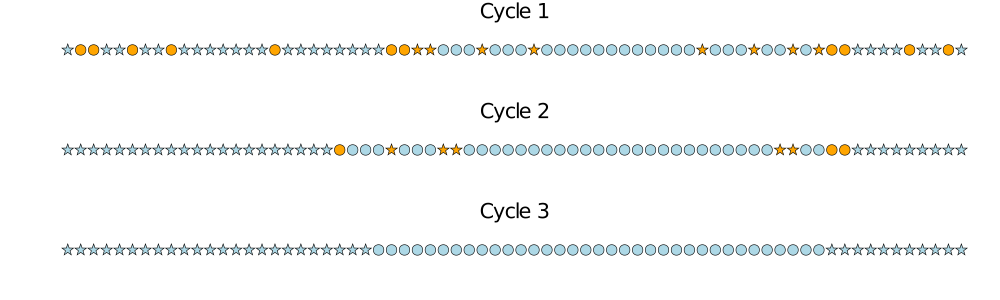

In [20]:
nh, results = run_simulation(Dict("Stars"=>35, "Circle"=>35), neighborhood_size=4, preference=0.5);
plot_results(results)

## Varying parameters

In [21]:
"Fraction of neighbors not like yourself"
function diversity_score(nh, agent_id)
    neighborhood_size = 4
    a = nh.agents[agent_id]
    neighbors = [
      [nh.locations[i] for i in max(a.location - neighborhood_size, 1):a.location-1];
      [nh.locations[i] for i in a.location+1:min(a.location + neighborhood_size, nh.size)]
    ]
    neighbors_kind = [a.kind for a in neighbors]
    cmap = countmap(neighbors_kind)
    score = 1 - (get(cmap, a.kind, 0) / length(neighbors))
    return min(score / 0.5, 1) # 0.5 is the default agents max acceptable preference
end

diversity_score

In [22]:
function get_metric(simulation)
    nh, results = simulation
    frac_happy = sum([is_happy(nh, i) for i in 1:nh.size]) / nh.size
    has_converged = frac_happy == 1 ? true : false
    num_cycles = length(results) - 1 #Last plot shows final state
    score = sum([diversity_score(nh, i) for i in 1:nh.size]) / nh.size * 100 
    return frac_happy, has_converged, num_cycles, score
end

get_metric (generic function with 1 method)

In [23]:
experiment = [run_simulation(Dict("Stars"=>35, "Circle"=>35), neighborhood_size=4, preference=0.5) for i in 1:500];

Broadcast operator .
- An alternative to vectorized operation which allows the caller to decide which function to vectorize  
- `f.x` corresponds to `broadcast(f, x)`  
- This allow nested dot calls to be fused into a single loop which makes it much more performant. See this blog post for more information: https://julialang.org/blog/2017/01/moredots/

In [24]:
df = get_metric.(experiment) |> DataFrame
rename!(df, ["frac_happy", "has_converged", "num_cycles", "score"])
df.row = axes(df, 1)
sort!(df, :score)
first(df, 3)

,frac_happy,has_converged,num_cycles,score,row
,Float64,Bool,Int64,Float64,Int64
1,1.0,1,1,14.2857,187
2,1.0,1,2,21.4286,15
3,1.0,1,2,21.4286,315


In [25]:
last(df, 3)

,frac_happy,has_converged,num_cycles,score,row
,Float64,Bool,Int64,Float64,Int64
1,0.957143,0,3,73.0816,434
2,0.971429,0,3,79.3027,125
3,0.985714,0,3,79.9354,303


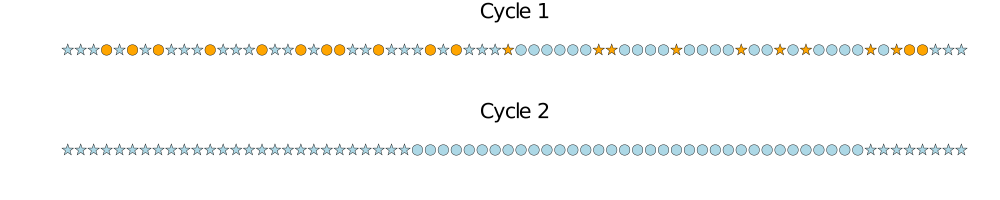

In [26]:
lowest_diversity = filter(row -> row[:has_converged] == 1,df) |> first
_, results = experiment[lowest_diversity.row]
plot_results(results)

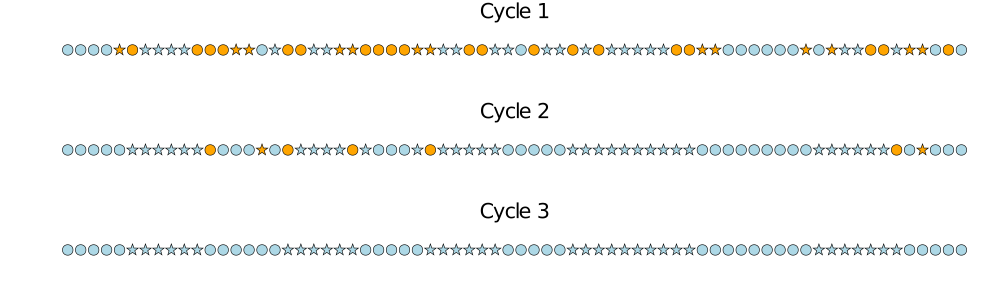

In [27]:
highest_diversity = filter(row -> row[:has_converged] == 1,df) |> last
_, results = experiment[highest_diversity.row]
plot_results(results)

## Varying neighborhood size and preference ratio

In [28]:
experiment2 = [run_simulation(Dict("Stars"=>35, "Circle"=>35), neighborhood_size=8, preference=0.5) for i in 1:500];
df2 = get_metric.(experiment2) |> DataFrame
rename!(df2, ["frac_happy", "has_converged", "num_cycles", "score"]);

In [29]:
experiment3 = [run_simulation(Dict("Stars"=>35, "Circle"=>35), neighborhood_size=4, preference=0.3) for i in 1:500];
df3 = get_metric.(experiment3) |> DataFrame
rename!(df3, ["frac_happy", "has_converged", "num_cycles", "score"]);

In [30]:
describe(df)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Nothing,DataType
1,frac_happy,0.989257,0.942857,1.0,1.0,,,Float64
2,has_converged,0.542,0,1.0,1,,,Bool
3,num_cycles,2.516,1,2.0,5,,,Int64
4,score,47.2086,14.2857,50.0,79.9354,,,Float64
5,row,250.5,1,250.5,500,,,Int64


In [31]:
describe(df2)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Nothing,DataType
1,frac_happy,0.979486,0.885714,0.985714,1.0,,,Float64
2,has_converged,0.472,0,0.0,1,,,Bool
3,num_cycles,3.166,1,3.0,5,,,Int64
4,score,26.0721,7.14286,28.5714,43.5136,,,Float64


In [32]:
describe(df3)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Nothing,DataType
1,frac_happy,0.941629,0.814286,0.942857,1.0,,,Float64
2,has_converged,0.02,0,0.0,1,,,Bool
3,num_cycles,2.528,1,3.0,4,,,Int64
4,score,77.8895,47.6531,79.0816,96.7857,,,Float64


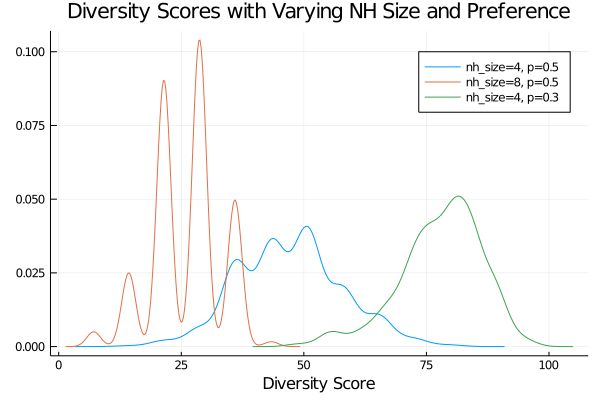

In [33]:
density(df.score, title="Diversity Scores with Varying NH Size and Preference", xaxis="Diversity Score", label="nh_size=4, p=0.5")
density!(df2.score, label="nh_size=8, p=0.5")
density!(df3.score, label="nh_size=4, p=0.3")

## Varying neighborhood composition

In [34]:
experiment4 = [run_simulation(Dict("Stars"=>50, "Circle"=>50), neighborhood_size=4, preference=0.5) for i in 1:500];
df4 = get_metric.(experiment4) |> DataFrame
rename!(df4, ["frac_happy", "has_converged", "num_cycles", "score"]);

In [35]:
experiment5 = [run_simulation(Dict("Stars"=>35, "Circle"=>65), neighborhood_size=4, preference=0.5) for i in 1:500];
df5 = get_metric.(experiment5) |> DataFrame
rename!(df5, ["frac_happy", "has_converged", "num_cycles", "score"]);

In [36]:
experiment6 = [run_simulation(Dict("Stars"=>20, "Circle"=>80), neighborhood_size=4, preference=0.5) for i in 1:500];
df6 = get_metric.(experiment6) |> DataFrame
rename!(df6, ["frac_happy", "has_converged", "num_cycles", "score"]);

In [37]:
describe(df4)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Nothing,DataType
1,frac_happy,0.99296,0.96,1.0,1.0,,,Float64
2,has_converged,0.582,0,1.0,1,,,Bool
3,num_cycles,2.506,1,2.0,4,,,Int64
4,score,47.2306,25.0,45.8357,70.8476,,,Float64


In [38]:
describe(df5)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Nothing,DataType
1,frac_happy,0.99436,0.96,1.0,1.0,,,Float64
2,has_converged,0.66,0,1.0,1,,,Bool
3,num_cycles,2.208,1,2.0,5,,,Int64
4,score,35.9291,15.0,35.8,55.3571,,,Float64


In [39]:
describe(df6)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Nothing,DataType
1,frac_happy,0.98374,0.8,1.0,1.0,,,Float64
2,has_converged,0.852,0,1.0,1,,,Bool
3,num_cycles,1.38,1,1.0,3,,,Int64
4,score,16.2037,5.0,10.0,55.9667,,,Float64


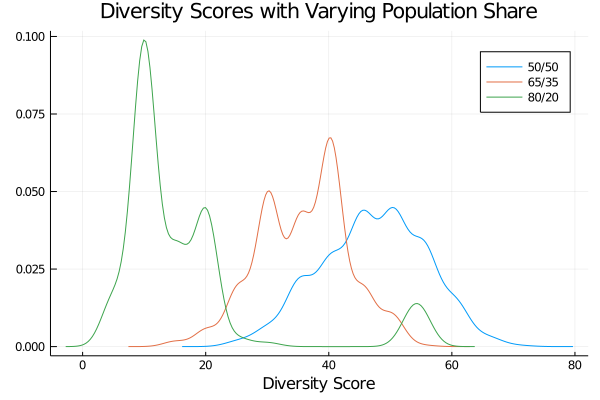

In [40]:
density(df4.score, title="Diversity Scores with Varying Population Share", xaxis="Diversity Score", label="50/50")
density!(df5.score, label="65/35")
density!(df6.score, label="80/20")

## Restricted Movement

In [41]:
# Modify the update function such that the search options is limited to nh.size / 2

function update!(nh, agent_id)
    # Choose nearest new locations until happy.
    a = nh.agents[agent_id]
    original_location = a.location
    options = [i % 2 == 1 ? ceil(Int64, i/2) : ceil(Int64, -i/2) for i in 1:nh.size/2]
    for i in options
        attempt_location = original_location + i
        if (0 < attempt_location <= nh.size)
            # @show (original_location, attempt_location)
            move_location!(nh, a, attempt_location)
            if is_happy(nh, agent_id)
                break
            elseif (i==options[end])
            # println(a, " Unable to find a satisfactory location")
            else
                # Revert
                move_location!(nh, a, original_location)
            end
        end
    end
end

update! (generic function with 1 method)

In [42]:
experiment4r = [run_simulation(Dict("Stars"=>50, "Circle"=>50), neighborhood_size=4, preference=0.5) for i in 1:500];
df4r = get_metric.(experiment4r) |> DataFrame
rename!(df4r, ["frac_happy", "has_converged", "num_cycles", "score"]);

In [43]:
describe(df4r)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Nothing,DataType
1,frac_happy,0.99242,0.96,1.0,1.0,,,Float64
2,has_converged,0.542,0,1.0,1,,,Bool
3,num_cycles,2.556,1,3.0,5,,,Int64
4,score,48.1284,25.0,50.0,75.5119,,,Float64


In [44]:
experiment6r = [run_simulation(Dict("Stars"=>20, "Circle"=>80), neighborhood_size=4, preference=0.5) for i in 1:500];
df6r = get_metric.(experiment6r) |> DataFrame
rename!(df6r, ["frac_happy", "has_converged", "num_cycles", "score"]);

In [45]:
describe(df6r)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Nothing,DataType
1,frac_happy,0.99012,0.8,1.0,1.0,,,Float64
2,has_converged,0.632,0,1.0,1,,,Bool
3,num_cycles,2.51,1,2.0,5,,,Int64
4,score,18.9092,5.0,20.0,52.5381,,,Float64
